In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs682/assignments/assignment3/'
FOLDERNAME = 'final_project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/Sharedrives/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import math
import torchvision
import torchvision.models as models
from collections import OrderedDict
from torchvision.models import ResNet18_Weights

###Data Processing

##Load Image

In [ ]:
def load_image():
  X = []
  Y = np.zeros((999, 10))
  i = 0
  j = 0
  for folder in os.listdir('/content/drive/Shareddrives/final_project/datasets/images_original'):
    print(folder)
    for file in tqdm(os.listdir('/content/drive/Shareddrives/final_project/datasets/images_original/' + folder)):
      img = Image.open('/content/drive/Shareddrives/final_project/datasets/images_original/' + folder + '/' + file)
      img = np.asarray(img)
      X.append(img)
      Y[j, i] = 1
      j+=1
    i+=1
  return np.array(X), Y

#0-metal
#1-classical
#2-hiphop
#3-country
#4-disco
#5-jazz
#6-reggae
#7-rock
#8-blues
#9-pop

In [ ]:
X_img, Y_img = load_image()
X_img = X_img[:, :, :, :3]

metal


100%|██████████| 100/100 [00:02<00:00, 41.05it/s]


classical


100%|██████████| 100/100 [00:02<00:00, 41.53it/s]


hiphop


100%|██████████| 100/100 [00:02<00:00, 41.71it/s]


country


100%|██████████| 100/100 [00:01<00:00, 52.61it/s]


disco


100%|██████████| 100/100 [00:02<00:00, 39.65it/s]


jazz


100%|██████████| 99/99 [00:52<00:00,  1.88it/s]


reggae


100%|██████████| 100/100 [00:02<00:00, 44.55it/s]


rock


100%|██████████| 100/100 [00:01<00:00, 51.91it/s]


blues


100%|██████████| 100/100 [00:02<00:00, 47.00it/s]


pop


100%|██████████| 100/100 [00:02<00:00, 47.59it/s]


In [ ]:
# centered = np.vectorize(zero_centered)
# mean = np.mean(X_img, axis = 0)
# X_img_centered = centered(X_img, mean)
# std = np.std(X_img_centered, axis = 0)
# normalized = np.vectorize(normalize)
# X_img_norm = normalized(X_img_centered, std)

### Dataset Shape

In [ ]:
print(X_img.shape)
print(Y_img.shape)
#print(X_img_norm.shape)
#print(X_img_norm[0])

(999, 288, 432, 3)
(999, 10)


### Image Shape

In [ ]:
print(X_img[0].shape)
print(Y_img[0].shape)
#print(X_img_norm[0].shape)
print(Y_img[0])

(288, 432, 3)
(10,)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Image Visualization

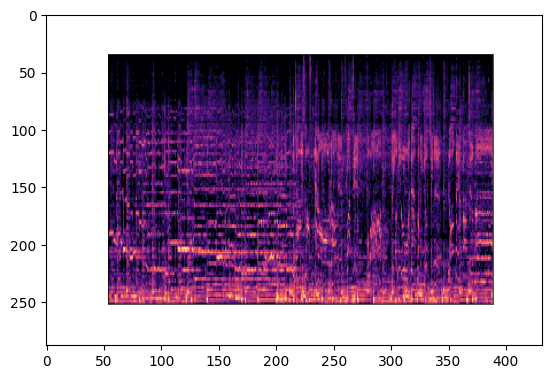

In [ ]:
plt.imshow(X_img[0])
#plt.imshow(X_img_norm[0])

### Train, Test split

In [ ]:
def train_test_split():
  x_img_train = None
  y_img_train = None
  x_img_test = None
  y_img_test = None
  norm = torchvision.transforms.Normalize(mean=[np.mean(X_img[:, :, :, 0]), np.mean(X_img[:, :, :, 1]), np.mean(X_img[:, :, :, 2])],
                                                std=[np.std(X_img[:, :, :, 0]), np.std(X_img[:, :, :, 1]), np.std(X_img[:, :, :, 2])])
  tempX = torch.as_tensor(X_img, dtype=torch.float).permute(0, 3, 1, 2)
  norm(tempX)

  x_img = tempX.numpy()

  x_img_train = np.concatenate((x_img[0:80], x_img[100:180], x_img[200:280], x_img[300:380], x_img[400:480],
                               x_img[500:580], x_img[600:680], x_img[700:780], x_img[800:880], x_img[900:980]))
  y_img_train = np.concatenate((Y_img[0:80], Y_img[100:180], Y_img[200:280], Y_img[300:380], Y_img[400:480],
                               Y_img[500:580], Y_img[600:680], Y_img[700:780], Y_img[800:880], Y_img[900:980]))

  x_img_test = np.concatenate((x_img[80:100], x_img[180:200], x_img[280:300], x_img[380:400], x_img[480:500],
                               x_img[580:600], x_img[680:700], x_img[780:800], x_img[880:900], x_img[980:999]))
  y_img_test = np.concatenate((Y_img[80:100], Y_img[180:200], Y_img[280:300], Y_img[380:400], Y_img[480:500],
                               Y_img[580:600], Y_img[680:700], Y_img[780:800], Y_img[880:900], Y_img[980:999]))

  return torch.as_tensor(x_img_train, dtype=torch.float), torch.as_tensor(y_img_train, dtype=torch.float), torch.as_tensor(x_img_test, dtype=torch.float), torch.as_tensor(y_img_test, dtype=torch.float)

In [ ]:
X_img_train, Y_img_train, X_img_test, Y_img_test = train_test_split()
X_img_train, Y_img_train, X_img_test, Y_img_test = X_img_train.to(torch.device("cuda:0")), Y_img_train.to(torch.device("cuda:0")), X_img_test.to(torch.device("cuda:0")), Y_img_test.to(torch.device("cuda:0"))

### Model

CNN_Resnet18

In [ ]:
class Resnet18:
  def __init__(self):
    self.resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    self.resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.resnet18.fc = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(512, 10)),
        ('output', nn.Softmax(dim=1))
    ]))
    self.resnet18.to(torch.device("cuda:0"))
    self.resnet18.train()

### Training

In [ ]:
def train(loss_function, input, label, epoch, lr):
  loss_hist = []
  model = Resnet18().resnet18
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  #input and label shuffle
  idx = np.random.permutation(input.shape[0])
  input, label = input[idx], label[idx]
  for _ in tqdm(range(epoch)):
    run_loss = 0.0
    for i in range(input.shape[0]):
      optimizer.zero_grad()
      tmp = input[i]
      tmp = tmp.unsqueeze(0)
      prediction = model(tmp)
      loss = loss_function(prediction.reshape(10,), torch.argmax(label[i]))
      run_loss += loss.to(torch.device("cpu")).detach().numpy()
      loss.backward()
      optimizer.step()
    loss_hist.append(run_loss)
  return model, loss_hist

### Evaluation and Hyper-tuning

In [ ]:
def evaluation(model, input, label):
  # model.eval()
  acc = 0
  for i in range(input.shape[0]):
    tmp = input[i]
    tmp = tmp.unsqueeze(0)
    prediction = model(tmp)
    acc += 1 if torch.argmax(prediction.reshape(10)) == torch.argmax(label[i]) else 0
  return acc/input.shape[0]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]
100%|██████████| 100/100 [19:17<00:00, 11.58s/it]


1/4
Best accuracy so far is 0.6984924623115578
Best ResNet18 accuracy is 0.6984924623115578
Best ResNet18 has a learning rate of 1e-05


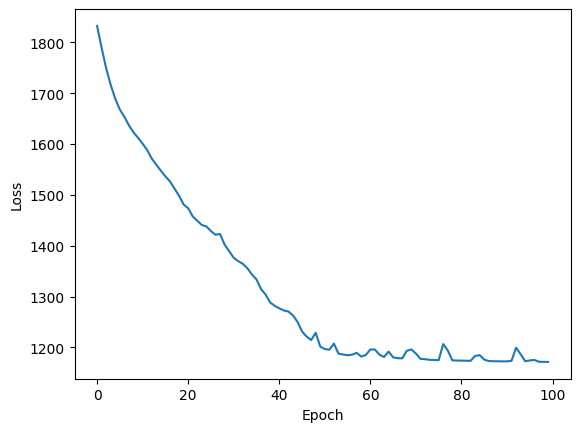

In [ ]:

def ResNet18_hyper_tuning():
  learning_rate = [1e-5]
  epoch = 100
  loss_function = nn.CrossEntropyLoss()
  best_accuracy = -math.inf
  best_lr = 0
  best_loss_hist = []
  count = 0
  for lr in learning_rate:
    model, loss_hist = train(loss_function, X_img_train, Y_img_train, epoch, lr)
    accuracy = evaluation(model, X_img_test, Y_img_test)
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_lr = lr
      best_loss_hist = loss_hist
    count += 1
    print(f'{count}/4')
    print(f'Best accuracy so far is {best_accuracy}')
  print(f'Best ResNet18 accuracy is {best_accuracy}')
  print(f'Best ResNet18 has a learning rate of {best_lr}')
  plt.plot(best_loss_hist, label="Training Loss History")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()
  plt.close()

ResNet18_hyper_tuning()